# Final Analysis

In [152]:
# Import required libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (accuracy_score, auc, classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, ConfusionMatrixDisplay)
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [154]:
# Copy DataFrame
df_analysis = pd.read_csv("nba_integrated_clean.csv")
df_analysis

,Season,Player,Team,Game Date,Minutes Played,Field Goals Made,Field Goals Attempted,Field Goal Percentage,Three Pointers Made,Three Pointers Attempted,...,Back-to-Back,Travel Distance,Season Avg Points,Season Avg Field Goal Percentage,Season Avg Three Point Percentage,Season Avg Plus Minus,Points Higher,FG% Higher,3P% Higher,Plus Minus Higher
0,2020-21,Ivica Zubac,Los Angeles Clippers,2020-12-22,26.516667,4,5,0.800,0,0,...,0,0.000000,9.027778,0.651847,0.013889,2.541667,1,1,0,1
1,2020-21,Kelly Oubre Jr.,Golden State Warriors,2020-12-22,25.650000,3,14,0.214,0,6,...,0,0.000000,15.436364,0.425964,0.281018,-3.454545,0,0,0,0
2,2020-21,Stephen Curry,Golden State Warriors,2020-12-22,30.316667,7,21,0.333,2,10,...,0,0.000000,31.984127,0.481397,0.411778,3.873016,0,0,0,0
3,2020-21,Kevin Durant,Brooklyn Nets,2020-12-22,24.933333,7,16,0.438,1,2,...,0,0.000000,26.942857,0.569286,0.486371,7.971429,0,0,1,1
4,2020-21,Terance Mann,Los Angeles Clippers,2020-12-22,1.043333,0,1,0.000,0,0,...,0,0.000000,7.044776,0.442060,0.286075,0.462687,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101383,2023-24,Anthony Black,Orlando Magic,2024-04-14,5.266667,2,3,0.667,1,2,...,0,1064.430997,4.579710,0.379551,0.210377,-0.478261,1,1,1,1
101384,2023-24,Jared Butler,Washington Wizards,2024-04-14,30.850000,9,19,0.474,2,4,...,0,394.024962,6.275000,0.468625,0.239175,-1.200000,1,1,1,1
101385,2023-24,Bryce McGowens,Charlotte Hornets,2024-04-14,29.716667,6,14,0.429,2,6,...,0,550.538671,5.118644,0.338237,0.194356,-3.881356,1,1,1,0
101386,2023-24,Gary Harris,Orlando Magic,2024-04-14,27.783333,1,4,0.250,1,4,...,0,859.533694,6.888889,0.441444,0.381537,1.685185,0,0,0,1


#### Univariate Visualizations

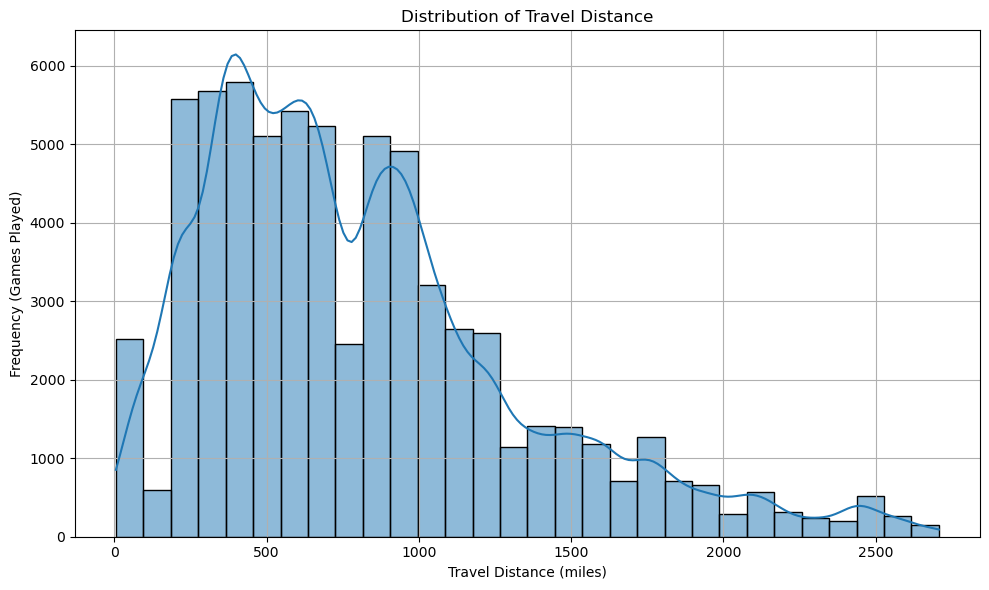

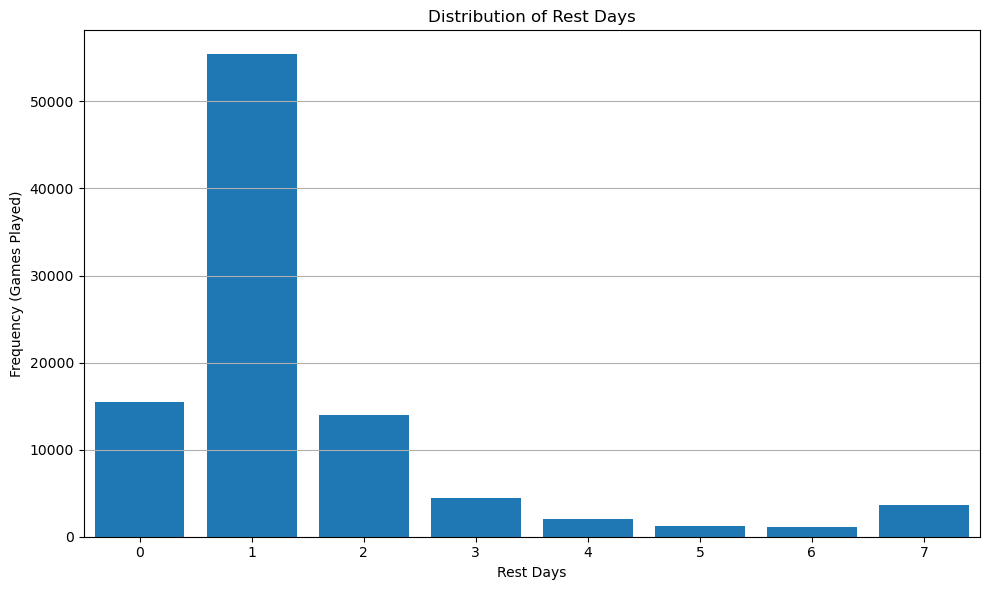

In [156]:
# Filter out rows where Travel Distance is 0
travel_filtered_df = df_analysis[df_analysis['Travel Distance'] > 0]

# Plot Travel Distance distribution
plt.figure(figsize=(10, 6))
sns.histplot(travel_filtered_df['Travel Distance'], bins=30, kde=True)
plt.title('Distribution of Travel Distance')
plt.xlabel('Travel Distance (miles)')
plt.ylabel('Frequency (Games Played)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Rest Days distribution
rest_day_counts = df_analysis['Rest Days'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.bar(rest_day_counts.index, rest_day_counts.values, width=0.8, align='center')
plt.title('Distribution of Rest Days')
plt.xlabel('Rest Days')
plt.ylabel('Frequency (Games Played)')
plt.xticks(range(0, 9))
plt.xlim(-0.5, 7.5)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

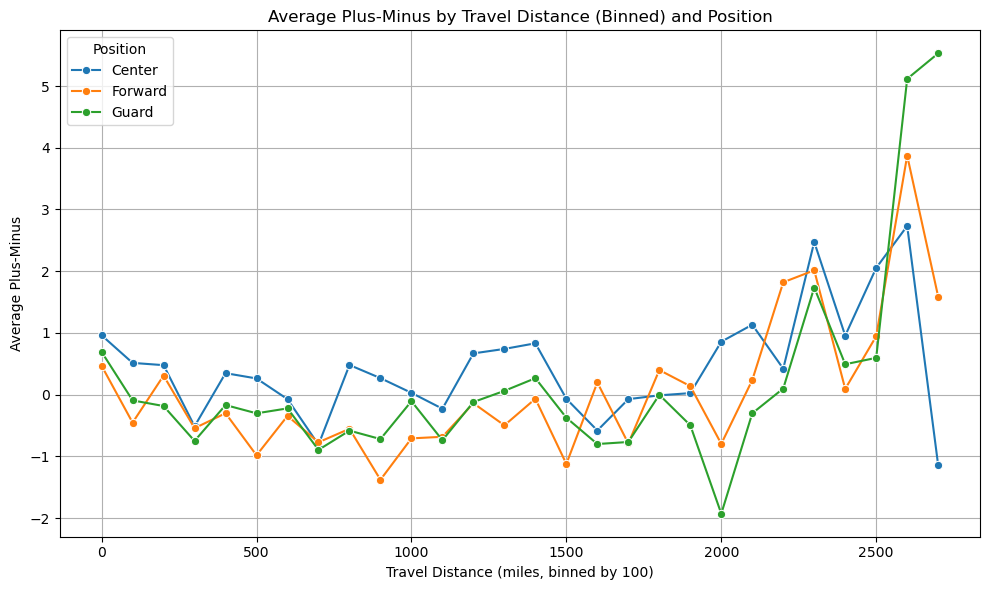

In [157]:
# Bin Travel Distance
df_analysis['Travel Bin'] = (df_analysis['Travel Distance'] // 100) * 100

# Grouping by Position and Bins
avg_plus_minus = df_analysis.groupby(['Position', 'Travel Bin'])['Plus Minus'].mean().reset_index()

# Bivariate Visualization
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_plus_minus, x='Travel Bin', y='Plus Minus', hue='Position', marker='o')
plt.title('Average Plus-Minus by Travel Distance (Binned) and Position')
plt.xlabel('Travel Distance (miles, binned by 100)')
plt.ylabel('Average Plus-Minus')
plt.grid(True)
plt.tight_layout()
plt.show()

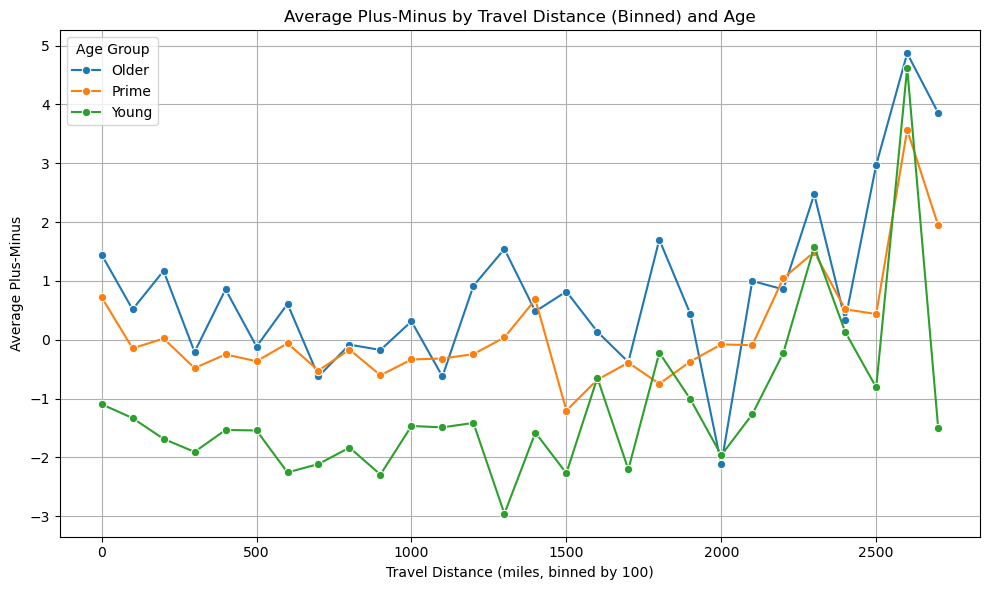

In [158]:
# Age Binning
def classify_age(age):
    if age < 25:
        return 'Young'
    elif age <= 30:
        return 'Prime'
    else:
        return 'Older'

df_analysis['Age Group'] = df_analysis['Age'].apply(classify_age)

# Group by Age Group Travel Distance
avg_plus_minus = df_analysis.groupby(['Age Group', 'Travel Bin'])['Plus Minus'].mean().reset_index()

# Bivariate Visualization pt.2
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_plus_minus, x='Travel Bin', y='Plus Minus', hue='Age Group', marker='o')
plt.title('Average Plus-Minus by Travel Distance (Binned) and Age')
plt.xlabel('Travel Distance (miles, binned by 100)')
plt.ylabel('Average Plus-Minus')
plt.grid(True)
plt.tight_layout()
plt.show()

In [159]:
# Extracting Plus-Minus for each group
plus_minus_center = df_analysis[df_analysis['Position'] == 'Center']['Plus Minus']
plus_minus_forward = df_analysis[df_analysis['Position'] == 'Forward']['Plus Minus']
plus_minus_guard = df_analysis[df_analysis['Position'] == 'Guard']['Plus Minus']

# ANOVA Test
f_stat, p_val = f_oneway(plus_minus_center, plus_minus_forward, plus_minus_guard)

print("ANOVA Test Results:")
print("Travel Distance impact on Plus Minus by Position")
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_val}")

ANOVA Test Results:
Travel Distance impact on Plus Minus by Position
F-statistic: 13.494458726798173
P-value: 1.381054917686782e-06


In [161]:
# Extract Plus-Minus for each group
plus_minus_young = df_analysis[df_analysis['Age Group'] == 'Young']['Plus Minus']
plus_minus_prime = df_analysis[df_analysis['Age Group'] == 'Prime']['Plus Minus']
plus_minus_older = df_analysis[df_analysis['Age Group'] == 'Older']['Plus Minus']

# ANOVA Test
f_stat, p_val = f_oneway(plus_minus_young, plus_minus_prime, plus_minus_older)

print("ANOVA Test Results:")
print("Travel Distance impact on Plus Minus by Age Group")
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_val}")

ANOVA Test Results:
Travel Distance impact on Plus Minus by Age Group
F-statistic: 232.1175984444726
P-value: 2.6466767814307368e-101


#### Preprocessing

In [163]:
df_model = df_analysis.copy()

# Encode 'Location': Home = 1, Away = 0
df_model['Location'] = df_model['Location'].map({'Home': 1, 'Away': 0})

# Define features and target
travel_features = ['Rest Days', 'Travel Distance', 'Back-to-Back', 'Location']
target_col = 'Points Higher'  # You can switch this to any other target as needed

# Drop rows with missing target values (just in case)
df_model = df_model.dropna(subset=[target_col])

# Split data
train_data, temp_data = train_test_split(
    df_model, test_size=0.4, random_state=42, stratify=df_model[target_col]
)
val_data, test_data = train_test_split(
    temp_data, test_size=0.5, random_state=42, stratify=temp_data[target_col]
)

# Separate features and target
X_train = train_data[travel_features]
y_train = train_data[target_col]

X_val = val_data[travel_features]
y_val = val_data[target_col]

X_test = test_data[travel_features]
y_test = test_data[target_col]

# Fill NaNs with 0 (just to be safe)
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Validation set shape:", X_val_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

Training set shape: (60832, 4)
Validation set shape: (20278, 4)
Testing set shape: (20278, 4)


#### Logistic Regression

In [165]:
# Training logistic regression
logreg = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
logreg.fit(X_train_scaled, y_train)

# Cross-validated logistic regression to find best C
logreg_cv = LogisticRegressionCV(
    Cs=[1, 2, 10],
    cv=5,
    penalty='l2',
    solver='liblinear',
    scoring='roc_auc',
    random_state=42,
    max_iter=1000
)
logreg_cv.fit(X_train_scaled, y_train)

# Get best regularization strength
best_C = logreg_cv.C_[0]
print(f"Best regularization strength (C): {best_C}")

# Final model with best C
final_logreg = LogisticRegression(
    C=best_C,
    penalty='l2',
    solver='liblinear',
    random_state=42,
    max_iter=1000
)
final_logreg.fit(X_train_scaled, y_train)

# Predicting on validation set
logreg_predictions = final_logreg.predict(X_val_scaled)
logreg_pred_proba = final_logreg.predict_proba(X_val_scaled)[:, 1]

# Model Evaluation
print("Logistic Regression Performance on Validation Set:")
print("\nClassification Report:")
print(classification_report(y_val, logreg_predictions))
print("ROC AUC Score:", roc_auc_score(y_val, logreg_pred_proba))

Best regularization strength (C): 1
Logistic Regression Performance on Validation Set:

Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71     11190
           1       0.00      0.00      0.00      9088

    accuracy                           0.55     20278
   macro avg       0.28      0.50      0.36     20278
weighted avg       0.30      0.55      0.39     20278

ROC AUC Score: 0.53928270317279


C:\Users\evhai\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\evhai\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\evhai\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Decision Tree

In [167]:
# Training Decision Tree Model
dt = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42)
dt.fit(X_train_scaled, y_train)

# Getting predictions and probabilities
dt_predictions = dt.predict(X_val_scaled)
dt_pred_proba = dt.predict_proba(X_val_scaled)[:, 1]

# Model Evaluation
print("Decision Tree Performance on Validation Set:")
print("\nClassification Report:")
print(classification_report(y_val, dt_predictions))
print("ROC AUC Score:", roc_auc_score(y_val, dt_pred_proba))

Decision Tree Performance on Validation Set:

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.99      0.71     11190
           1       0.50      0.01      0.01      9088

    accuracy                           0.55     20278
   macro avg       0.52      0.50      0.36     20278
weighted avg       0.53      0.55      0.40     20278

ROC AUC Score: 0.5295674888529118


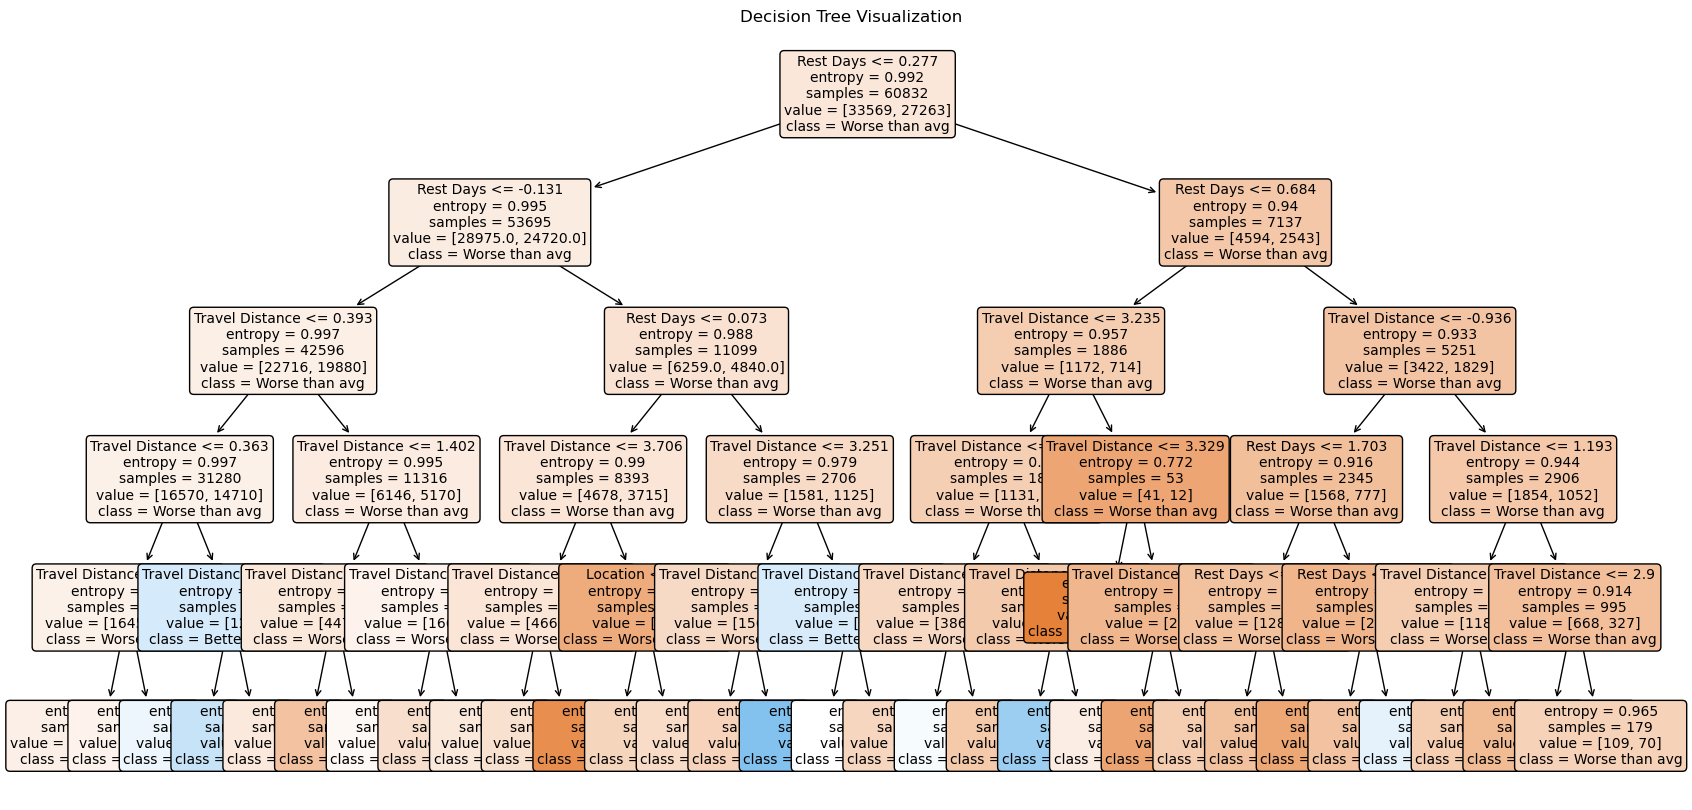

In [169]:
# Plotting the decision tree
plt.figure(figsize=(20,10))
plot_tree(
    dt,
    feature_names=X_train.columns,
    class_names=["Worse than avg", "Better than avg"],
    filled=True,
    rounded=True,
    fontsize=10,
)
plt.title("Decision Tree Visualization")
plt.show()

#### XGBoost

In [175]:
# Training XGBoost Classifier
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

# Predicting on validation set
y_val_pred = xgb_model.predict(X_val_scaled)
y_val_proba = xgb_model.predict_proba(X_val_scaled)[:, 1]

# Model Evaluation
print("XGBoost Performance on Validation Set:")
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_val_proba))

C:\Users\evhai\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:33:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Performance on Validation Set:
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.92      0.69     11190
           1       0.46      0.08      0.14      9088

    accuracy                           0.55     20278
   macro avg       0.51      0.50      0.42     20278
weighted avg       0.51      0.55      0.44     20278

ROC AUC Score: 0.5250451891700966


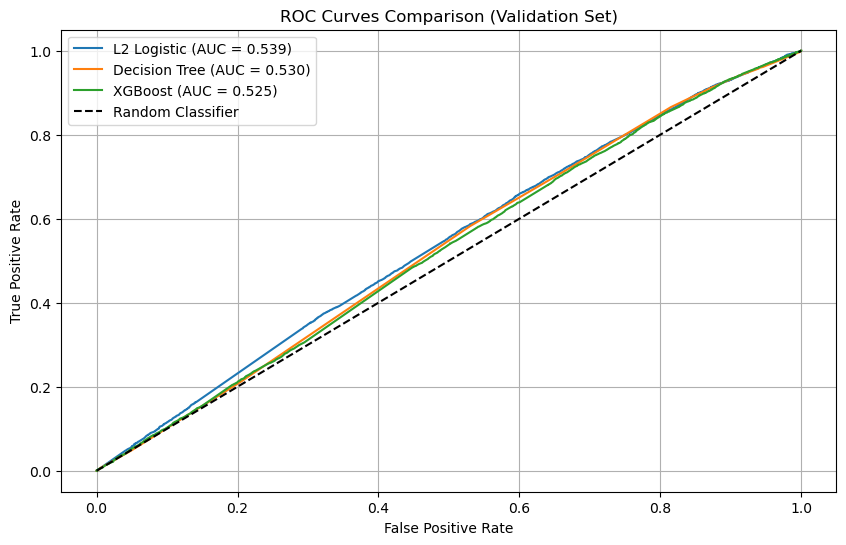

In [178]:
# Get prediction probabilities for all models
val_scores = {
    "L2 Logistic": final_logreg.predict_proba(X_val_scaled)[:, 1],
    "Decision Tree": dt.predict_proba(X_val_scaled)[:, 1],
    "XGBoost": xgb_model.predict_proba(X_val_scaled)[:, 1]
}

# Plot ROC Curve
plt.figure(figsize=(10,6))

for name, probas in val_scores.items():
    fpr, tpr, _ = roc_curve(y_val, probas)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

#### Time Series Analysis

C:\Users\evhai\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 6.32


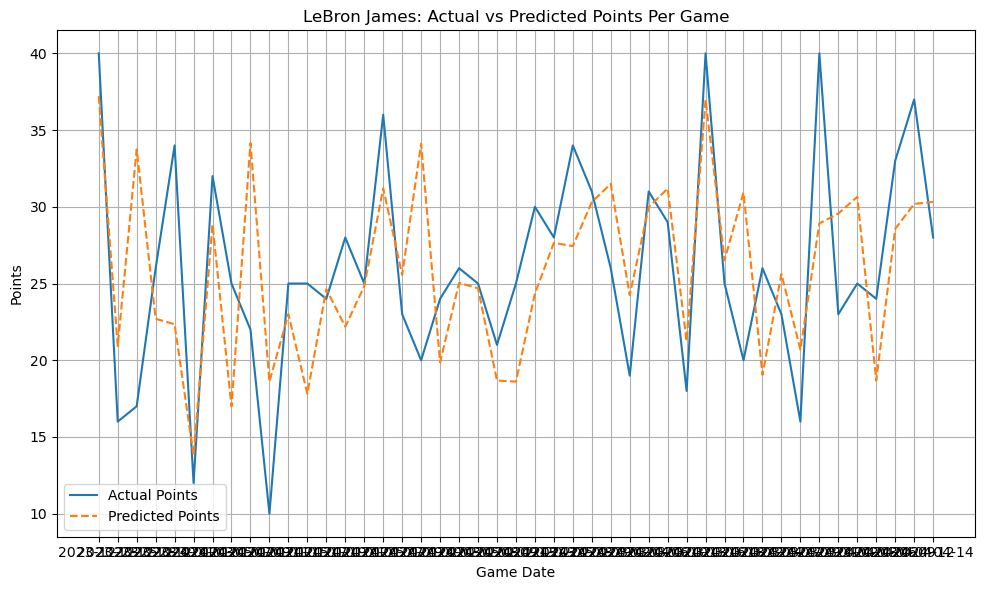

In [182]:
# Filter and prepare data for LeBron James
lebron_df = df_analysis[df_analysis['Player'] == 'LeBron James'].copy()
lebron_df = lebron_df.sort_values('Game Date')
lebron_df.set_index('Game Date', inplace=True)

# Create lag and rolling features
lebron_df['Points_Lag1'] = lebron_df['Points'].shift(1)
lebron_df['Points_MA3'] = lebron_df['Points'].rolling(window=3).mean()

# Drop rows with NaNs
model_df = lebron_df[['Points', 'Points_Lag1', 'Points_MA3']].dropna()

# Split into features and target
X = model_df[['Points_Lag1', 'Points_MA3']]
y = model_df['Points']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Fit XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual Points')
plt.plot(y_test.index, y_pred, label='Predicted Points', linestyle='--')
plt.title('LeBron James: Actual vs Predicted Points Per Game')
plt.xlabel('Game Date')
plt.ylabel('Points')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\evhai\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 4.53


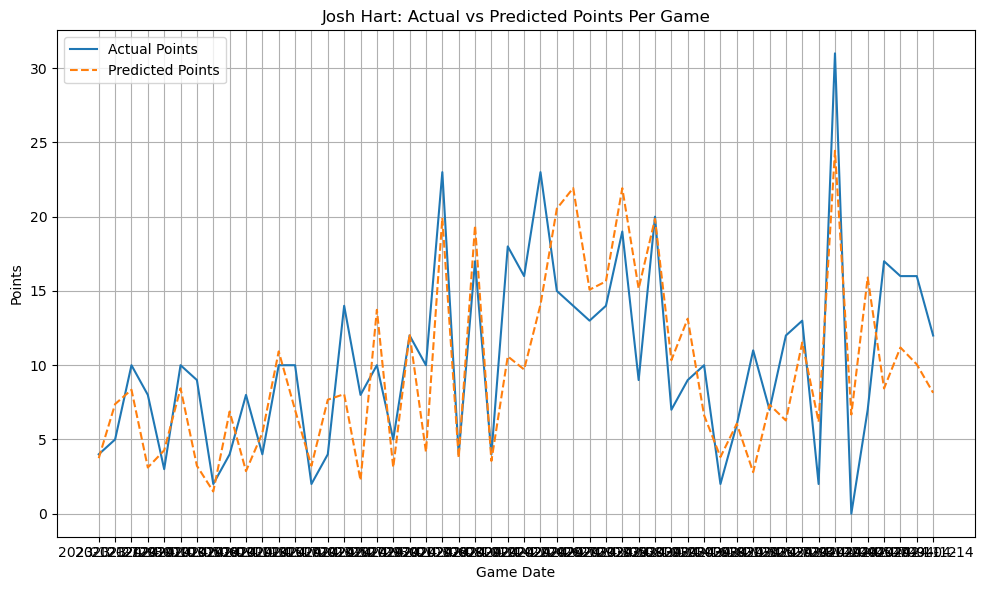

In [192]:
# Filter and prepare data for Josh Hart
hart_df = df_analysis[df_analysis['Player'] == 'Josh Hart'].copy()
hart_df = hart_df.sort_values('Game Date')
hart_df.set_index('Game Date', inplace=True)

# Create lag and rolling features
hart_df['Points_Lag1'] = hart_df['Points'].shift(1)
hart_df['Points_MA3'] = hart_df['Points'].rolling(window=3).mean()

# Drop rows with NaNs
model_df = hart_df[['Points', 'Points_Lag1', 'Points_MA3']].dropna()

# Split into features and target
X = model_df[['Points_Lag1', 'Points_MA3']]
y = model_df['Points']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Fit XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual Points')
plt.plot(y_test.index, y_pred, label='Predicted Points', linestyle='--')
plt.title('Josh Hart: Actual vs Predicted Points Per Game')
plt.xlabel('Game Date')
plt.ylabel('Points')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()